## Authorize Google Drive

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Import necessary libraries

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
from sklearn import model_selection
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Reshape, Bidirectional, GRU, Dense, Dropout
import matplotlib.pyplot as plt
import soundfile as sf
import os

## Download the ESC-50 dataset

In [ ]:
# url = "https://github.com/karoldvl/ESC-50/archive/master.tar.gz"
# download_path = "/content/gdrive/MyDrive/Colab Notebooks/KidSense/ESC-50.tar.gz"
# wget.download(url, download_path)

## Extract the downloaded dataset

In [ ]:
# tar = tarfile.open("ESC-50.tar.gz", "r:gz")
# tar.extractall()
# tar.close()

## Check if the dataset has been downloaded

In [ ]:
os.listdir("/content/gdrive/MyDrive/Colab Notebooks/KidSense/ESC-50-master")

['.circleci',
 'pytest.ini',
 'esc50.gif',
 '.github',
 '.gitignore',
 'README.md',
 'LICENSE',
 'meta',
 'tests',
 'audio',
 'requirements.txt',
 '.ipynb_checkpoints',
 'audioTests']


## Load the pre-trained model

In [ ]:
model = hub.load("https://tfhub.dev/google/yamnet/1")

## Load and preprocess the ESC-50 dataset

In [ ]:
metadata_path = "/content/gdrive/MyDrive/Colab Notebooks/KidSense/ESC-50-master/meta/esc50.csv"
audio_dir = "/content/gdrive/MyDrive/Colab Notebooks/KidSense/ESC-50-master/audio"

# Load metadata
metadata = pd.read_csv(metadata_path)

# Load audio data and extract features
features = []
labels = []

# Iterate over each row in the metadata
for i, row in metadata.iterrows():
    # Get the filename and label from the metadata
    filename = row["filename"]
    label = row["category"]

    # Construct the path to the audio file
    audio_path = f"{audio_dir}/{filename}"

    # Decode the waveform and obtain the sample rate
    waveform, sample_rate = tf.audio.decode_wav(tf.io.read_file(audio_path))
    waveform = tf.squeeze(waveform)
    waveform = waveform / tf.abs(waveform).numpy().max()  # Normalize waveform

    # Extract features using YAMNet
    scores, embeddings, spectrogram = model(waveform)
    averaged_embedding = tf.reduce_mean(embeddings, axis=0).numpy()

    # Append the features, label, and fold to the lists
    features.append(averaged_embedding)
    labels.append(label)


# Convert features, label, and folds lists to numpy arrays
features = np.array(features)
labels = np.array(labels)

## Split the dataset into training and testing sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

## Encode the categorical labels

In [ ]:
# Convert the target labels to integer-encoded form
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

## One-hot encode the target labels

In [ ]:
num_classes = len(label_encoder.classes_)
y_train_one_hot = to_categorical(y_train_encoded, num_classes)
y_test_one_hot = to_categorical(y_test_encoded, num_classes)

## Reshape the feature arrays to match the input shape of the model

In [ ]:
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, 1, X_train.shape[1])
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, 1, X_test.shape[1])

## Define and compile the CNN model

In [ ]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (1, 1), activation='relu', input_shape=(1, 1, features.shape[1])),
    tf.keras.layers.MaxPooling2D((1, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Reshape((1, -1)),  # Reshape for RNN input

    # Add recurrent layers (e.g., LSTM or GRU)
    Bidirectional(GRU(64, return_sequences=True)),
    Bidirectional(GRU(64)),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(num_classes, activation='softmax')
])
my_model.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=['accuracy'])



# **TRUE CNN model**

In [ ]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (1, 1), activation='relu', input_shape=(1, 1, features.shape[1])),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(64, (1, 1), activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

my_model.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=['accuracy'])



# RNN model

In [ ]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Reshape((1, -1), input_shape=(1, 1, features.shape[1])),  # Reshape for RNN input

    # Add recurrent layers (e.g., LSTM or GRU)
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128)),
    #tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(num_classes, activation='softmax')
])

my_model.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Bidirectional, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adamax

my_model = Sequential([
    tf.keras.layers.Reshape((1, -1), input_shape=(1, 1, features.shape[1])),  # Reshape for RNN input

    # Add recurrent layers (e.g., LSTM or GRU)
    Bidirectional(GRU(256, return_sequences=True)),
    Bidirectional(GRU(128, return_sequences=True)),
    Bidirectional(GRU(128)),
    Dropout(0.4),

    Dense(128, activation='relu'),
    Dropout(0.1),

    Dense(64, activation='relu'),
    Dropout(0.4),

    Dense(num_classes, activation='softmax')
])

my_model.compile(optimizer="Adamax", loss='categorical_crossentropy', metrics=['accuracy'])


## Train the CNN model

In [ ]:
batch_size = 256
epochs = 100

history = my_model.fit(X_train_reshaped, y_train_one_hot,
                       batch_size=batch_size, epochs=epochs,
                       validation_data=(X_test_reshaped, y_test_one_hot))


Epoch 1/100
1/1 [==============================] - 17s 17s/step - loss: 1.1116 - accuracy: 0.2500 - val_loss: 1.1143 - val_accuracy: 0.2500
Epoch 2/100
1/1 [==============================] - 0s 73ms/step - loss: 1.0389 - accuracy: 0.5521 - val_loss: 1.0964 - val_accuracy: 0.3333
Epoch 3/100
1/1 [==============================] - 0s 57ms/step - loss: 1.0001 - accuracy: 0.5833 - val_loss: 1.0719 - val_accuracy: 0.6667
Epoch 4/100
1/1 [==============================] - 0s 56ms/step - loss: 0.9650 - accuracy: 0.6458 - val_loss: 1.0477 - val_accuracy: 0.5833
Epoch 5/100
1/1 [==============================] - 0s 52ms/step - loss: 0.9275 - accuracy: 0.6667 - val_loss: 1.0299 - val_accuracy: 0.5833
Epoch 6/100
1/1 [==============================] - 0s 52ms/step - loss: 0.8929 - accuracy: 0.6667 - val_loss: 1.0117 - val_accuracy: 0.5833
Epoch 7/100
1/1 [==============================] - 0s 55ms/step - loss: 0.8503 - accuracy: 0.6250 - val_loss: 0.9925 - val_accuracy: 0.5833
Epoch 8/100
1/1 [===

In [ ]:
# # tf.saved_model.save(my_model, '/content/saved_model')
# # Convert the SavedModel to TensorFlow Lite format
# converter = tf.lite.TFLiteConverter.from_saved_model('/content/saved_model')

# # Enable support for select TensorFlow ops and disable lowering tensor list ops
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
# converter._experimental_lower_tensor_list_ops = False

# # Convert the model
# tflite_model = converter.convert()

# # Save the TensorFlow Lite model
# with open('/content/tflite_model.tflite', 'wb') as f:
#     f.write(tflite_model)

saved_model_path = '/content/model'
tf.saved_model.save(my_model, saved_model_path)

In [ ]:
my_model.save('/content/model.h5')

In [ ]:
model = tf.keras.models.load_model('/content/model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
!tensorflowjs_converter --input_format=keras /content/model.h5 /content/tfjs/model

'8.4.3.1'

## Evaluate the CNN model on the test set

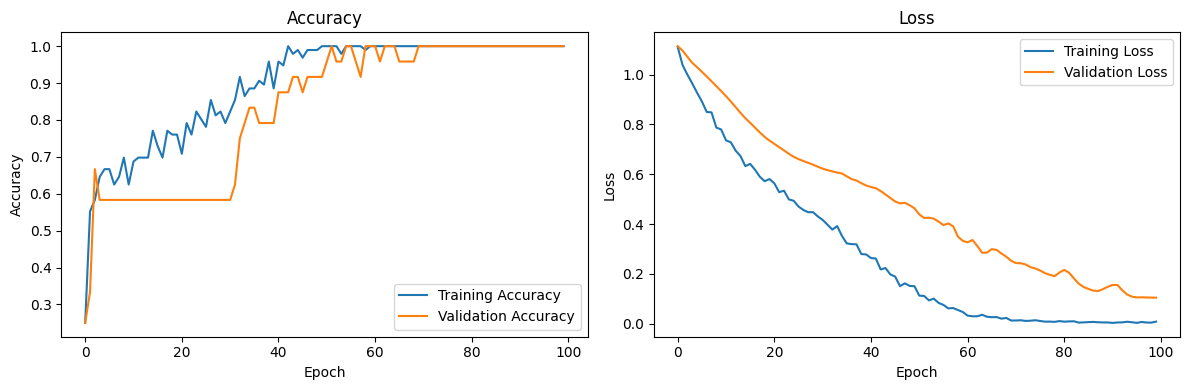

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

## Real-time prediction using the microphone

In [ ]:
duration = 5  # Duration of recording in seconds
sample_rate = 16000  # Sample rate of the microphone

def predict_audio(input_audio):
    waveform = input_audio / np.abs(input_audio).max()  # Normalize waveform

    # Extract features using YAMNet
    scores, embeddings, spectrogram = model(waveform)
    averaged_embedding = tf.reduce_mean(embeddings, axis=0).numpy()
    input_feature = averaged_embedding.reshape(1, 1, 1, -1)

    # Perform prediction using the trained CNN model
    prediction = model_cnn.predict(input_feature)
    predicted_label_encoded = np.argmax(prediction)
    predicted_label = label_encoder.inverse_transform([predicted_label_encoded])

    return predicted_label[0], prediction[0, predicted_label_encoded]

## Record audio from the microphone

In [ ]:
# Record audio from the default input device
print("Recording audio...")
audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1)
sd.wait()  # Wait for the recording to complete
audio = audio.flatten()

# Make a prediction on the recorded audio
predicted_label, confidence = predict_audio(audio)
print("Predicted Label:", predicted_label)
print("Confidence:", confidence)

## Load and preprocess a newly imported audio file

In [ ]:
new_audio_path = "/content/gdrive/MyDrive/Colab Notebooks/KidSense/ESC-50-master/audioTests/wings.wav"
# Load audio data using soundfile and convert to 16-bit
waveform_new, sample_rate_new = sf.read(new_audio_path, dtype='int16')

# Check if the audio is stereo
if waveform_new.shape[-1] == 2:
    # Convert stereo to mono
    waveform_new = tf.reduce_mean(waveform_new, axis=-1)

waveform_new = waveform_new / tf.abs(waveform_new).numpy().max()  # Normalize waveform

# Extract features using YAMNet
scores_new, embeddings_new, spectrogram_new = model(waveform_new)
averaged_embedding_new = tf.reduce_mean(embeddings_new, axis=0).numpy()

# Reshape the feature vector for the CNN model
feature_new_cnn = averaged_embedding_new.reshape(1, 1, 1, averaged_embedding_new.shape[0])

# Classify the new audio using the trained CNN model
predictions = my_model.predict(feature_new_cnn)
predicted_class_index = np.argmax(predictions)
predicted_class = label_encoder.inverse_transform([predicted_class_index])[0]
certainty = predictions[0][predicted_class_index] * 100  # Get the certainty in percentage

print("Predicted class:", predicted_class)
print("Certainty:", certainty, "%")


1/1 [==============================] - 0s 149ms/step
Predicted class: door_wood_knock
Certainty: 49.352067708969116 %
